In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from agent.setTransfomer import setTransformer
from torch.utils.tensorboard import SummaryWriter

st = setTransformer(n_feature=6, num_heads=3, encoder_fc_hiddens=[128], encoder_depth=1, 
                    initial_fc_hiddens=[512]*2,
                    initial_fc_output=12,
                    n_output=48, pma_fc_hiddens=[128], pma_mab_fc_hiddens=[128], 
                    mhAtt_dropout=0.2, fc_dropout=0.5).to("cuda")
linear = torch.nn.Linear(48, 3).to(st.device)
model = torch.nn.Sequential(st, linear)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

from env.propagators.variableDebris import vdPropagator, vdPropagatorPlane
# vdp = vdPropagator(10, 0.06, dt=0.3, device="cuda", safe_dist=100, p_new_debris=1e-3, gamma=None)
vdp = vdPropagatorPlane(10, 0.06, dt=0.3, device="cuda", safe_dist=100, p_new_debris=5e-2, gamma=None)

In [2]:
from utils import lineProj, dotEachRow
def _gen_data(batch_size=64, batch_num=1000, n_debris=None):
    if n_debris is None:
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
    total = batch_size*batch_num
    data = torch.zeros((total, n_debris, 6), device=vdp.device)
    label = torch.zeros((total, 1), device=vdp.device)
    for j in range(batch_num):
        sp = vdp.randomPrimalStates(batch_size)
        sd = vdp.randomDebrisStatesTime(n_debris)
        op, od = vdp.getObss(sp, sd)
        data[j*batch_size:(j+1)*batch_size] = od
    pos = data[:,:,:3]
    vel = data[:,:,3:]
    dist = pos.norm(dim=-1)
    _, min_idx = dist.min(dim=1)
    for i in range(total):
        label[i,...] = dist[i, min_idx[i]]
    return data, label

def _get_pool(total_p, total_d):
    sp_pool = vdp.randomPrimalStates(total_p)
    sd_pool = vdp.randomDebrisStatesTime(total_d)
    return sp_pool, sd_pool

def _gen_pool_data(p_pool, d_pool, batch_size, n_debris:int|None=None):
    if n_debris is None:
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
    p_idx = np.random.choice(p_pool.shape[0], batch_size, replace=False)
    d_idx = np.random.choice(d_pool.shape[0], batch_size*n_debris, replace=False)
    data = torch.zeros((batch_size, n_debris, 6), device=vdp.device)
    label = torch.zeros((batch_size, 1), device=vdp.device)
    for i in range(batch_size):
        sp = p_pool[[p_idx[i]],:]
        sd = d_pool[d_idx[i*n_debris:(i+1)*n_debris],:]
        op, od = vdp.getObss(sp, sd)
        data[i:i+1] = od
    pos = data[:,:,:3]
    vel = data[:,:,3:]
    dist = pos.norm(dim=-1)
    _, min_idx = dist.min(dim=1)
    for i in range(batch_size):
        label[i,...] = dist[i, min_idx[i]]
    return data, label

In [3]:
from utils import lineProj, dotEachRow
from env.propagators.variableDebris import vdPropagator, vdPropagatorPlane
# vdp = vdPropagator(10, 0.06, dt=0.3, device="cuda", safe_dist=100, p_new_debris=1e-3, gamma=None)
vdp = vdPropagatorPlane(10, 0.06, dt=0.3, device="cuda", safe_dist=100, p_new_debris=5e-2, gamma=None)

def _gen_data(batch_size=64, batch_num=1000, n_debris=None):
    if n_debris is None:
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
    total = batch_size*batch_num
    data = torch.zeros((total, n_debris, 6), device=vdp.device)
    label = torch.zeros((total, 3), device=vdp.device)
    for j in range(batch_num):
        sp = vdp.randomPrimalStates(batch_size)
        sd = vdp.randomDebrisStatesTime(n_debris)
        op, od = vdp.getObss(sp, sd)
        data[j*batch_size:(j+1)*batch_size] = od
    pos = data[:,:,:3]
    vel = data[:,:,3:]
    dr = dotEachRow(pos, vel)
    _, closet_approach = lineProj(torch.zeros_like(pos), pos, vel)
    closet_dist = closet_approach.norm(dim=-1) # (batch_size, n_debris)
    closet_dist = torch.where(dr<0, closet_dist, torch.inf)
    _, min_idx = closet_dist.min(dim=1)
    for i in range(total):
        label[i,...] = closet_approach[i, min_idx[i],:]
    return data, label

def _get_pool(total_p, total_d):
    sp_pool = vdp.randomPrimalStates(total_p)
    sd_pool = vdp.randomDebrisStatesTime(total_d)
    return sp_pool, sd_pool

def _gen_pool_data(p_pool, d_pool, batch_size, n_debris:int|None=None):
    if n_debris is None:
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
    p_idx = np.random.choice(p_pool.shape[0], batch_size, replace=False)
    d_idx = np.random.choice(d_pool.shape[0], batch_size*n_debris, replace=False)
    data = torch.zeros((batch_size, n_debris, 6), device=vdp.device)
    label = torch.zeros((batch_size, 3), device=vdp.device)
    for i in range(batch_size):
        sp = p_pool[[p_idx[i]],:]
        sd = d_pool[d_idx[i*n_debris:(i+1)*n_debris],:]
        op, od = vdp.getObss(sp, sd)
        data[i:i+1] = od
    pos = data[:,:,:3]
    vel = data[:,:,3:]
    dr = dotEachRow(pos, vel)
    _, closet_approach = lineProj(torch.zeros_like(pos), pos, vel)
    closet_dist = closet_approach.norm(dim=-1) # (batch_size, n_debris)
    closet_dist = torch.where(dr<0, closet_dist, torch.inf)
    _, min_idx = closet_dist.min(dim=1)
    for i in range(batch_size):
        label[i,...] = closet_approach[i, min_idx[i],:]
    return data, label

In [16]:
from agent.net import fcNet
linear_pretrainer_model = fcNet(6, 3, [512]*4).to("cuda")
opt = torch.optim.Adam(linear_pretrainer_model.parameters(), lr=0.001)

In [48]:
writer = SummaryWriter(log_dir="./tblogs")
test_data = _gen_data(10, 1)[0]
writer.add_graph(model, test_data)

In [55]:
Data, Label = [[] for _ in range(vdp.max_n_debris)], [[] for _ in range(vdp.max_n_debris)]

In [79]:
for i in range(vdp.max_n_debris):
    Data[i] = torch.cat(Data[i], dim=0)
    Label[i] = torch.cat(Label[i], dim=0)

In [91]:
def _load_data(batch_size, n_debris=None):
    if n_debris is None:
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
    idx = np.random.choice(Data[n_debris-1].shape[0], batch_size, replace=False)
    return Data[n_debris-1][idx], Label[n_debris-1][idx]

In [ ]:
n_epoch = 1000
n_episode = 100
batch_size = 1024
n_feat = st.n_feature
# n_debris = 1
for epoch in range(n_epoch):
    for episode in range(n_episode):
        model.train()
        n_debris = np.random.randint(1, vdp.max_n_debris+1)
        # data, label = _gen_data(1, batch_size, n_debris)
        data, label = _load_data(batch_size, n_debris)
        data, label = data.to(vdp.device), label.to(vdp.device)
        # Data[n_debris-1].append(data.cpu())
        # Label[n_debris-1].append(label.cpu())
        pred = model(data).view(label.shape)
        loss = torch.nn.functional.mse_loss(pred, label)
        opt.zero_grad()
        loss.backward()
        opt.step()
        writer.add_scalar("loss/train", loss.item(), epoch*n_episode+episode)
    model.eval()
    test_data, test_label = _gen_data(1, batch_size)
    test_pred = model(test_data).view(label.shape)
    test_loss = torch.nn.functional.mse_loss(test_pred, test_label)
    writer.add_scalar("loss/test", test_loss.item(), epoch*n_episode+episode)

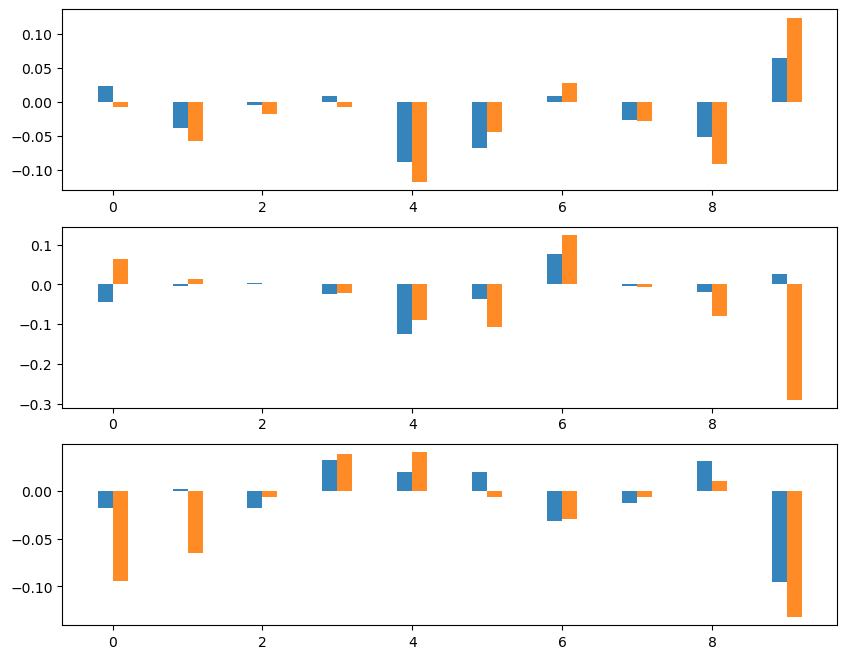

In [97]:
import matplotlib.pyplot as plt
st.eval()
test_batch_size = 10
n_debris = 10
# test_data, test_label = _gen_pool_data(pp, dp, test_batch_size, n_debris)
test_data, test_label = _gen_data(1, test_batch_size, n_debris)

test_pred = model(test_data).view(test_label.shape)
test_pred = test_pred.detach().cpu().numpy()
test_label = test_label.detach().cpu().numpy()
fig, axs = plt.subplots(test_pred.shape[-1], figsize=(10,8))
if test_pred.shape[-1]==1:
    axs = [axs]
xpos = np.arange(test_batch_size)
width = 0.2
for i in range(test_pred.shape[-1]):
    bars1 = axs[i].bar(xpos-width/2, test_pred[:,i], align='center', width=width, alpha=0.9, color='#1f77b4', label = 'Pred')
    bars2 = axs[i].bar(xpos+width/2, test_label[:,i], align='center', width=width, alpha=0.9, color='#ff7f0e', label = 'Label')

In [99]:
torch.save(model.state_dict(), '../model/pretrained_st.pt')